In [1]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.visualization import ZScaleInterval

In [2]:
def Fits_Array(a, extract_exptime=False):
    """Función para generar un array tridimensional de imágenes, siendo 'a'
    una lista con los pathnames de las imágenes que se quiere estackear"""
    b=np.empty([4096,4096,0])
    expt_list=[]
    for i in range(len(a)):
        x=fits.open(a[i])
        b=np.dstack((b,np.array(x[0].data)))
        if extract_exptime==True:
            expt_list.append(x[0].header['EXPTIME'])
    if extract_exptime==True:
        return b,expt_list
    else:
        return b

In [3]:
def Plots(cube,rows,columns,contr,direc_name,im_name,size_x=30,size_y=30):
    """Función para plotear la imágenes de un cubo, se pueden ajustar tanto el tamaño de las filas y columnas como el tamaño de
    la figura completa, hay que dar valores para los topes del cmap (por default es gray)"""
    fig=plt.figure(figsize=(size_x,size_y))
    for i in range (cube.shape[2]):
        zscale=ZScaleInterval(contrast=contr)
        minv,maxv=zscale.get_limits(cube[:,:,i])
        fig.add_subplot(rows,columns,i+1).imshow(cube[:,:,i],vmin=minv,vmax=maxv,cmap='gray')
    plt.savefig(f"{direc_name}/{im_name}.png",facecolor='white')

In [4]:
def Redux(obj,ff,dn):
    """obj:object,ff=filter,dn=directory name"""
    im_table=pd.read_fwf('imagelist.txt')
    
    #Listas con los nombres de los archivos a utilizar
    light_list=im_table[(im_table["Type"]=='Light Frame')&(im_table["Object"]==f"{obj}")&(im_table["Filter"]==f"{ff}")]["File_Name"].tolist()
    bias_list=im_table[im_table["Type"]=='Bias Frame']["File_Name"].tolist()
    flat_list=im_table[(im_table["Type"]=='Flat Field')&(im_table["Filter"]==f"{ff}")]["File_Name"].tolist()
    
    #Cubos de datos y listas de tiempos de exposición
    lights=Fits_Array(light_list,extract_exptime=True) #Tupla cubo,exptimes
    bias=Fits_Array(bias_list) #Solo el cubo
    flats=Fits_Array(flat_list,extract_exptime=True) #Tupla cubo,exptimes
    
    #Lista reducida de tiempos de exposición
    redux_explist=list(set(lights[1]))
    redux_explist.extend(list(set(flats[1])))
    
    #Dark cube
    dark_cube=np.empty([4096,4096,0])
    dark_exp_list=[]
    for i in redux_explist:
        dark_list=im_table[(im_table["Type"]=='Dark Frame')&(im_table["Exp_Time_(s)"]==i)]["File_Name"].tolist()
        dark_mini_cube=Fits_Array(dark_list,extract_exptime=True)
        dark_cube=np.dstack((dark_cube,dark_mini_cube[0]))
        dark_exp_list.extend(dark_mini_cube[1])
    darks=dark_cube,dark_exp_list

    #Masters
    Master_Bias=np.nanmedian(bias,axis=2) 
    Master_Dark_cube=np.empty([4096,4096,0])
    for i in redux_explist:
        mdark=np.nanmedian(darks[0][:,:,np.array(darks[1])==i],axis=2)
        Master_Dark_cube=np.dstack((Master_Dark_cube,mdark))
        
    #Limpiar los flat y normalizar
    Master_Flat=np.empty([4096,4096,0])
    for i in range(len(flats[1])):
        redu_f=flats[0][:,:,i]-Master_Dark_cube[:,:,np.array(redux_explist)==10].squeeze(axis=2)
        Master_Flat=np.dstack((Master_Flat,redu_f))
    Norm_master_flat=np.mean(Master_Flat,axis=2)/np.nanmedian(Master_Flat,axis=2)
    
    #Reduccion
    reducc=np.empty([4096,4096,0])
    for i in range (len(lights[1])):
        oper=lights[1][i]*((lights[0][:,:,i]-Master_Dark_cube[:,:,np.array(redux_explist)==lights[1][i]].squeeze(axis=2)))/Norm_master_flat
        reducc=np.dstack((reducc,oper))
    prod=np.sum(reducc,axis=2)/np.sum(np.array(lights[1]))
    
    #Weight maps
    weight_cube=np.empty([4096,4096,0])
    for i in (list(set(lights[1]))):
        weight_map=np.full((4096,4096),i)
        weight_cube=np.dstack((weight_cube,weight_map))
    
    #Plots
    zscale=ZScaleInterval(contrast=0.02)
    minv,maxv=zscale.get_limits(prod)
    plt.figure(figsize = (20,20))
    plt.imshow(prod,vmin=minv,vmax=maxv,cmap="binary_r")
    plt.savefig(f"{dn}/final.png",facecolor='white')
    Plots(lights[0],1,3,0.04,dn,"raw")
    Plots(bias,5,2,0.25,dn,"bias",size_y=80)
    Plots(darks[0],3,3,0.25,dn,"dark")
    Plots(flats[0],3,2,0.5,dn,"flat",size_y=50)
    return prod,weight_cube.squeeze(axis=2)

/tmp/ipykernel_6290/2100167214.py:41: RuntimeWarning: invalid value encountered in true_divide
  Norm_master_flat=np.mean(Master_Flat,axis=2)/np.nanmedian(Master_Flat,axis=2)


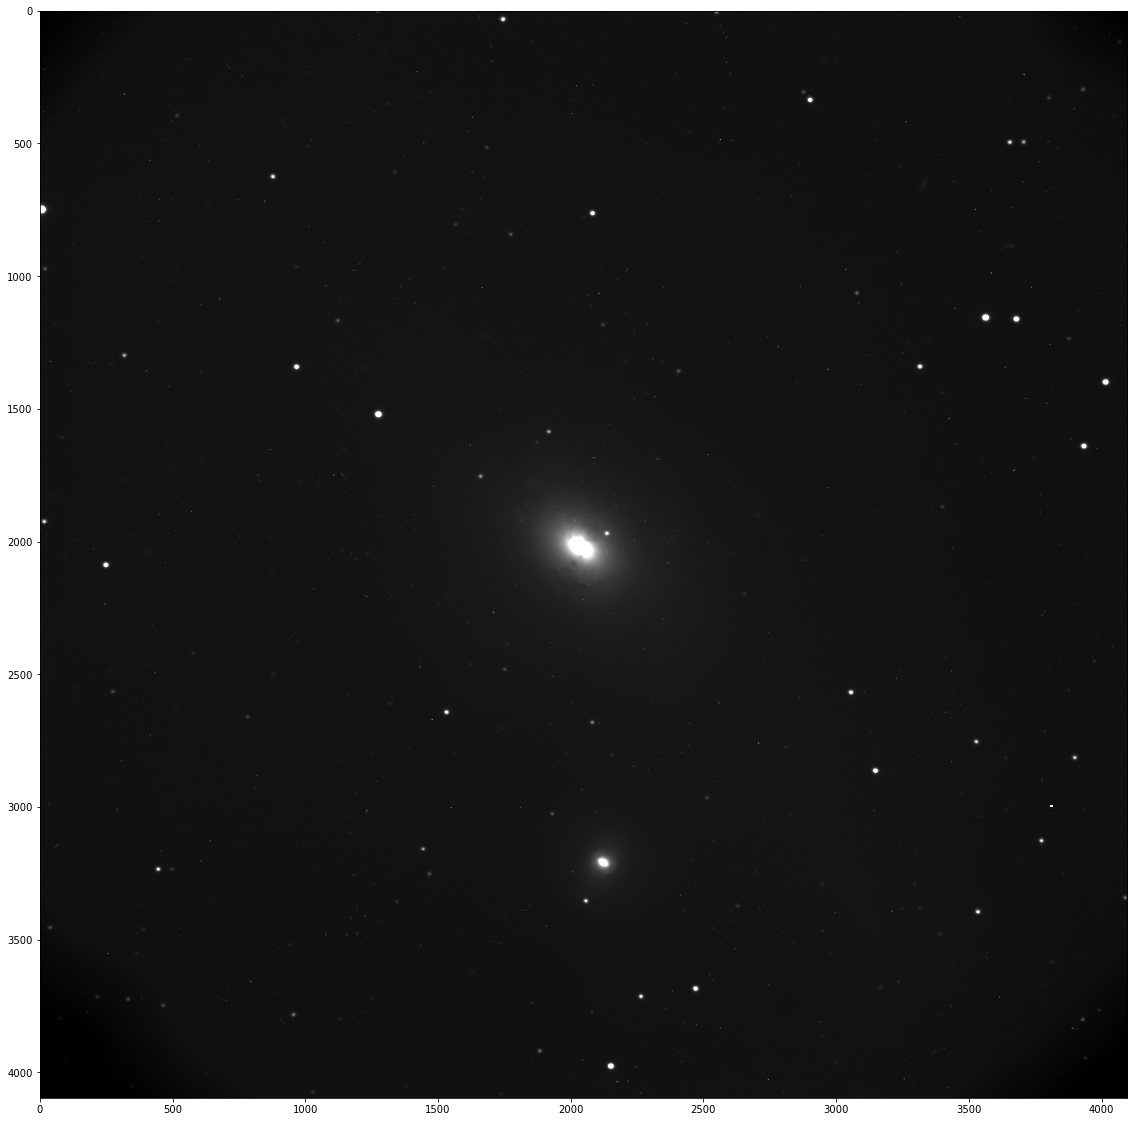

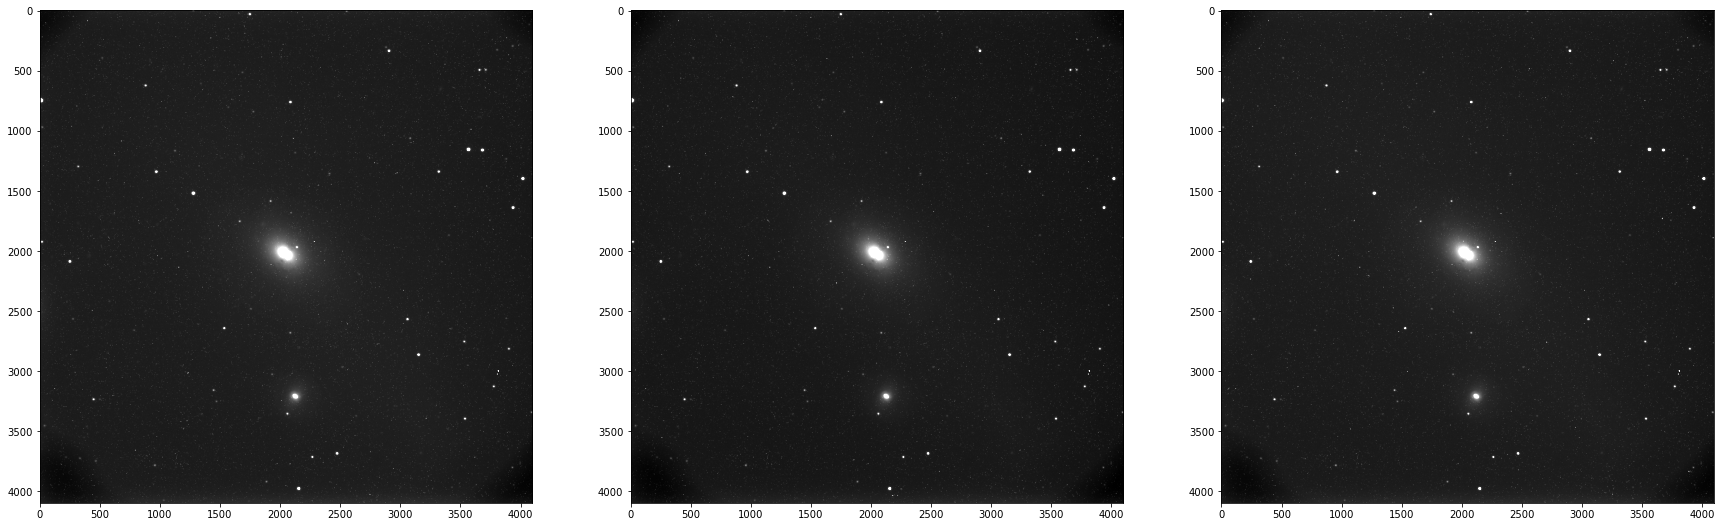

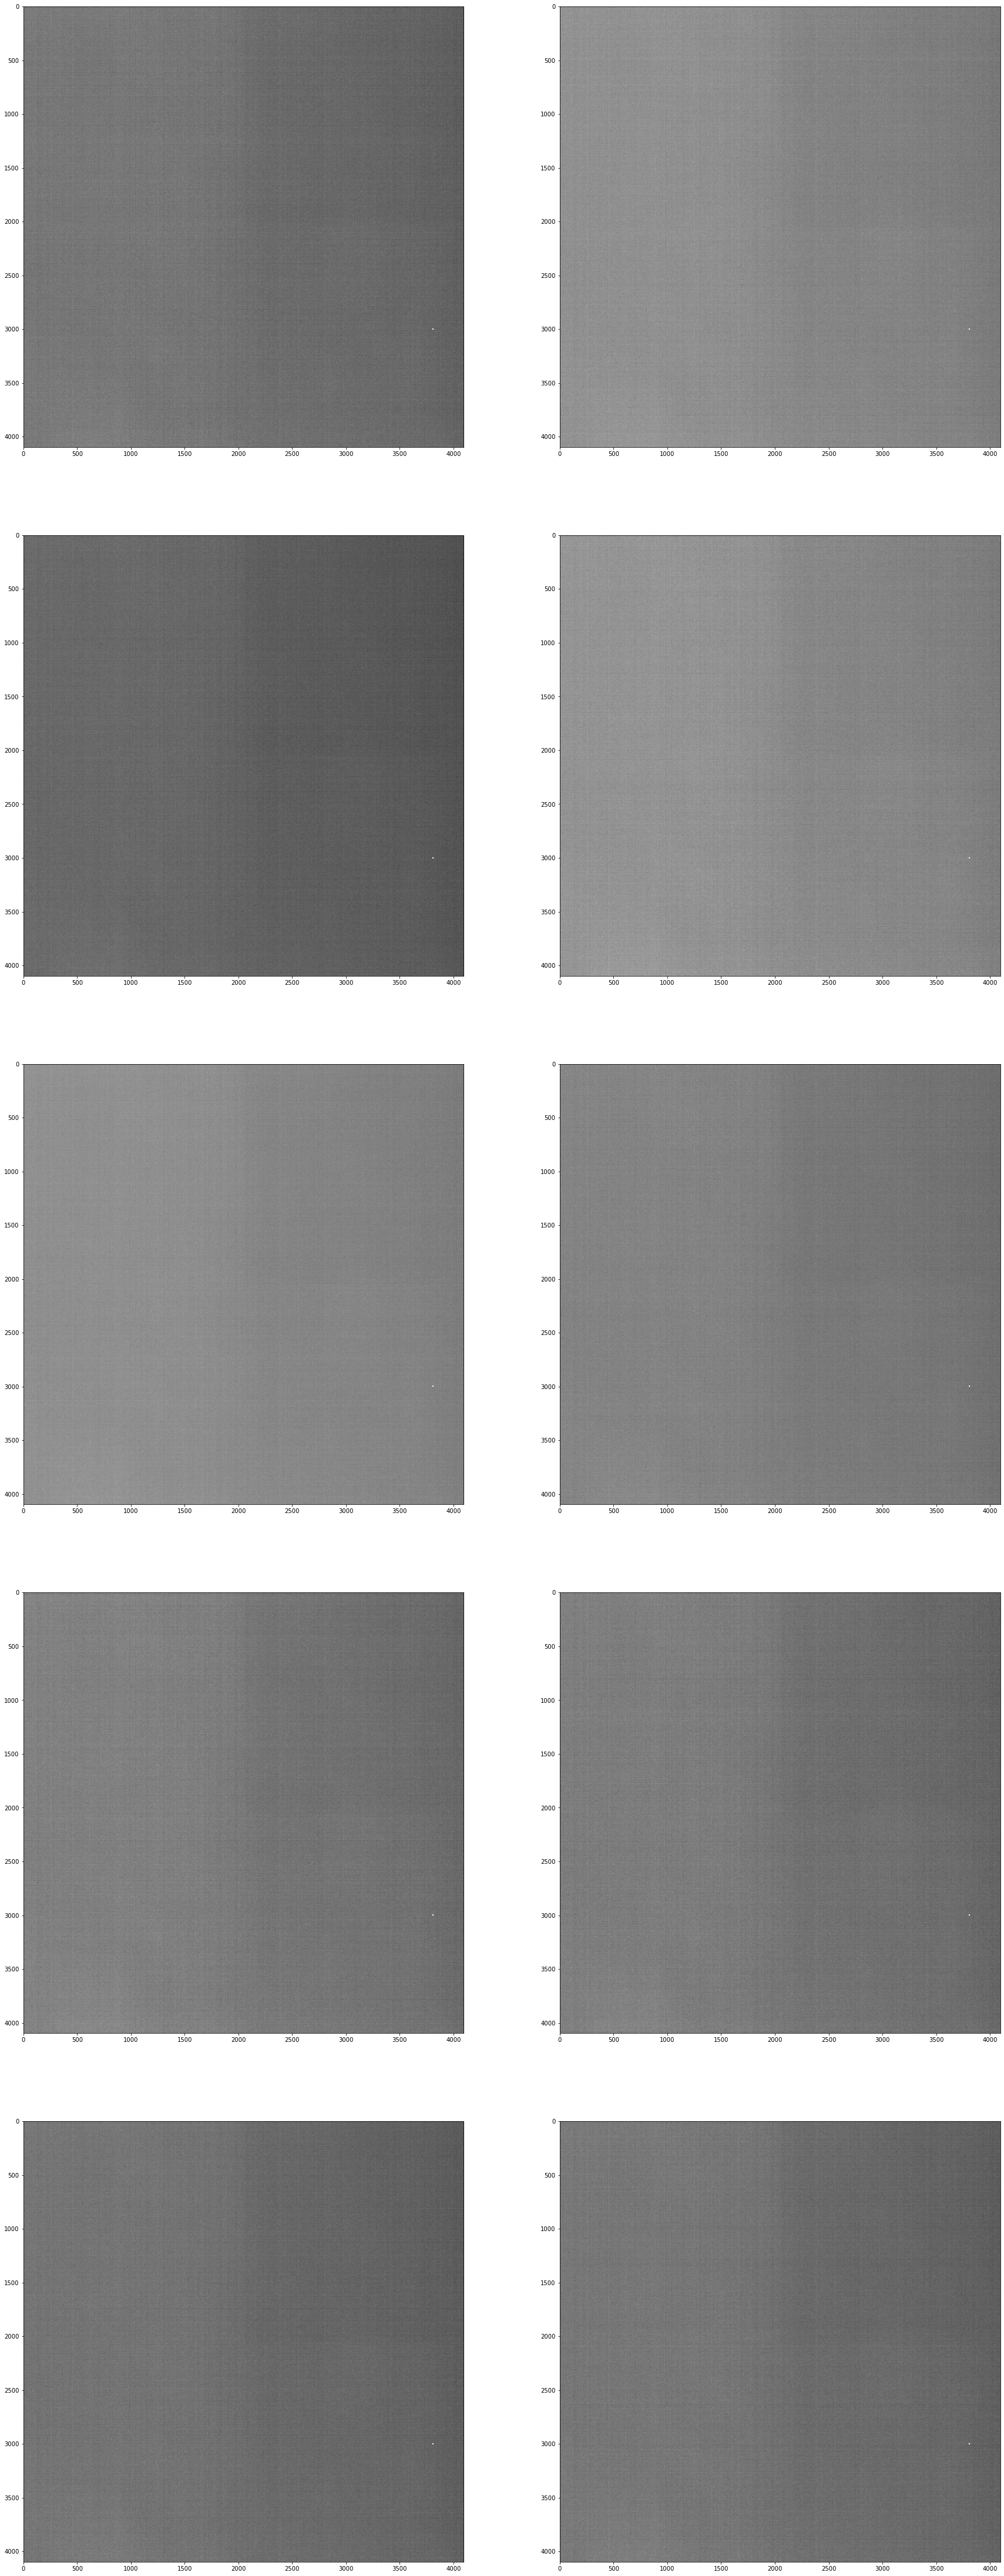

In [ ]:
test=Redux("NGC 1316","V","Images")

In [ ]:
test[1].shape